# 0.0 Imports

In [353]:
import re
import os
import inflection

import pandas            as  pd
import numpy             as  np 
import seaborn           as sns
import matplotlib.pyplot as plt

from sklearn.metrics         import mean_absolute_error, mean_squared_error
from sklearn.ensemble        import RandomForestRegressor
from sklearn.linear_model    import LinearRegression, Lasso 
from sklearn.preprocessing   import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

## 0.1 Helper Functions

In [366]:
def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r,k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

## 0.2 Loading data

### Dict of data

city: Cidade em que se localiza o imovel 

area: m² do imovel

rooms: Quantidade de salas

bathroom: Quantidade de banheiros

parking spaces: Se possui vaga de garagem

floor: Andar em que o apto se encontra

animal: Se aceita ou não animal

furniture: Mobiliado ou não

hoa (R$): Valor do condominio

rent amount (R$): Valor do aluguel

property tax (R$): Valor do IPTU

fire insurance (R$): Valor do Seguro contra Incendio

total (R$): Somatoria do valor do Condominio + aluguel + IPTU + Seguro contra incendio

In [265]:
path = "../data/"
df_raw = pd.read_csv(path + "/raw/house_data.csv", sep = ",")

In [266]:
df_raw.sample()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
10064,São Paulo,98,2,2,0,8,acept,not furnished,600,4500,0,58,5158


In [267]:
#Will not use columns fire insurance (R$) and total (R$)
df_raw.drop(columns= ["fire insurance (R$)", "total (R$)"], inplace = True)
df_raw.head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$)
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25


# 1.0 Data Description

In [322]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [323]:
df1.columns

Index(['city', 'area', 'rooms', 'bathroom', 'parking spaces', 'floor',
       'animal', 'furniture', 'hoa (R$)', 'rent amount (R$)',
       'property tax (R$)'],
      dtype='object')

In [324]:
cols_new = ['city','area','rooms','bathroom','parking_spaces','floor',
'animal','furniture','hoa','rent_amount',
'property_tax']

In [325]:
df1.columns = cols_new
df1.columns

Index(['city', 'area', 'rooms', 'bathroom', 'parking_spaces', 'floor',
       'animal', 'furniture', 'hoa', 'rent_amount', 'property_tax'],
      dtype='object')

## 1.2. Data Dimensions

In [326]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 10692
Number of Columns: 11


## 1.3. Data Types

In [327]:
df1.dtypes

city              object
area               int64
rooms              int64
bathroom           int64
parking_spaces     int64
floor             object
animal            object
furniture         object
hoa                int64
rent_amount        int64
property_tax       int64
dtype: object

## 1.4. Check NA

In [328]:
df1.isnull().sum()

city              0
area              0
rooms             0
bathroom          0
parking_spaces    0
floor             0
animal            0
furniture         0
hoa               0
rent_amount       0
property_tax      0
dtype: int64

## 1.5. Check Unique Values

In [329]:
df1.nunique()

city                 5
area               517
rooms               11
bathroom            10
parking_spaces      11
floor               35
animal               2
furniture            2
hoa               1679
rent_amount       1195
property_tax      1243
dtype: int64

## 1.6. Cleaning Data

In [330]:
num_attributes = df1.select_dtypes(include = ["int64"])
cat_attributes = df1.select_dtypes(exclude = ["int64"])

In [331]:
# Check Categorical Variables
for column in cat_attributes:

    check_cat = df1[column].value_counts(normalize=True) * 100

    print(column, '\n', check_cat, '\n')

city 
 São Paulo         55.059858
Rio de Janeiro    14.038533
Belo Horizonte    11.765806
Porto Alegre      11.157875
Campinas           7.977927
Name: city, dtype: float64 

floor 
 -      23.017209
1      10.110363
2       9.212495
3       8.707445
4       6.995885
5       5.611672
6       5.041152
7       4.648335
8       4.582866
9       3.451178
10      3.338945
11      2.833895
12      2.403666
13      1.870557
14      1.589974
15      1.374860
16      1.019454
17      0.897868
18      0.701459
19      0.495698
20      0.411523
21      0.392817
25      0.233820
23      0.233820
22      0.224467
26      0.187056
24      0.177703
27      0.074822
28      0.056117
29      0.046764
32      0.018706
35      0.009353
46      0.009353
301     0.009353
51      0.009353
Name: floor, dtype: float64 

animal 
 acept        77.777778
not acept    22.222222
Name: animal, dtype: float64 

furniture 
 not furnished    75.626637
furnished        24.373363
Name: furniture, dtype: float64 



In [332]:
# Fixing column floor
df1.iloc[2562, 5] = 30

df1['floor'] = df1['floor'].apply(lambda x: 0 if x == '-' else x)

df1['floor'] = pd.to_numeric(df1['floor'])


In [333]:
num_attributes1 = df1.select_dtypes(include = ["int64"])
cat_attributes1 = df1.select_dtypes(exclude = ["int64"])

In [334]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes1.apply(np.mean)).T
ct2 = pd.DataFrame( num_attributes1.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes1.apply(np.std)).T
d2 = pd.DataFrame(num_attributes1.apply(min)).T
d3 = pd.DataFrame(num_attributes1.apply(max)).T
d4 = pd.DataFrame(num_attributes1.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes1.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes1.apply(lambda x: x.kurtosis())).T

# Concatenate
m = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ["attributes","min","max","range","mean","median","std","skew","kurtosis"]

In [335]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,area,11.0,46335.0,46324.0,149.217920,90.0,536.991829,69.596804,5548.308334
1,rooms,1.0,13.0,12.0,2.506079,2.0,1.171211,0.702391,1.487659
2,bathroom,1.0,10.0,9.0,2.236813,2.0,1.407132,1.213810,1.134852
3,parking_spaces,0.0,12.0,12.0,1.609147,1.0,1.589446,1.487534,2.769075
4,floor,0.0,51.0,51.0,5.042649,3.0,5.356925,1.435172,2.544460
5,hoa,0.0,1117000.0,1117000.0,1174.021698,560.0,15591.576074,69.039381,4912.249106
6,rent_amount,450.0,45000.0,44550.0,3896.247194,2661.0,3408.386117,1.838877,4.624228
7,property_tax,0.0,313700.0,313700.0,366.704358,125.0,3107.686983,96.013594,9667.782564


In [336]:
cat_attributes1.apply(lambda x: x.unique().shape[0])

city         5
animal       2
furniture    2
dtype: int64

## 1.7 treating outliers

In [343]:
df1.sort_values(by = 'parking_spaces', ascending = False).head(5)

,city,area,rooms,bathroom,parking_spaces,floor,animal,furniture,hoa,rent_amount,property_tax
4813,São Paulo,1600,4,5,12,0,acept,not furnished,1,6900,5000
5445,São Paulo,190,1,2,10,0,acept,not furnished,0,3900,34
3559,São Paulo,1100,4,6,10,0,acept,not furnished,3000,14000,2000
4027,São Paulo,320,5,3,8,0,acept,not furnished,0,14000,917
640,Belo Horizonte,1000,5,7,8,0,acept,not furnished,0,14980,1904


In [337]:
# Change outliers hoa and property_tax variables to median
hoa_outlier = df1['hoa']>220000
df1.loc[hoa_outlier, 'hoa'] = 560
df1.sort_values(by = 'hoa', ascending = False).head()

property_tax_outlier = df1['property_tax'] > 30000
df1.loc[property_tax_outlier, 'property_tax'] = 125
df1.sort_values(by = 'property_tax', ascending = False).head()

,city,area,rooms,bathroom,parking_spaces,floor,animal,furniture,hoa,rent_amount,property_tax
6243,Rio de Janeiro,95,2,2,1,11,acept,not furnished,1024,3000,28120
1699,São Paulo,700,4,4,4,0,acept,not furnished,0,10000,21880
10172,Belo Horizonte,260,4,4,6,10,acept,furnished,3200,11900,12500
5331,São Paulo,300,4,5,5,6,not acept,not furnished,3500,1990,10830
2928,Rio de Janeiro,35,1,1,0,1,acept,furnished,81150,4500,9900


# 2.0 EDA

In [338]:
df2 = df1.copy()

## 2.1. Numerical variables

In [339]:
num_cols = df2.columns[df2.dtypes != object]
len(num_cols)

8

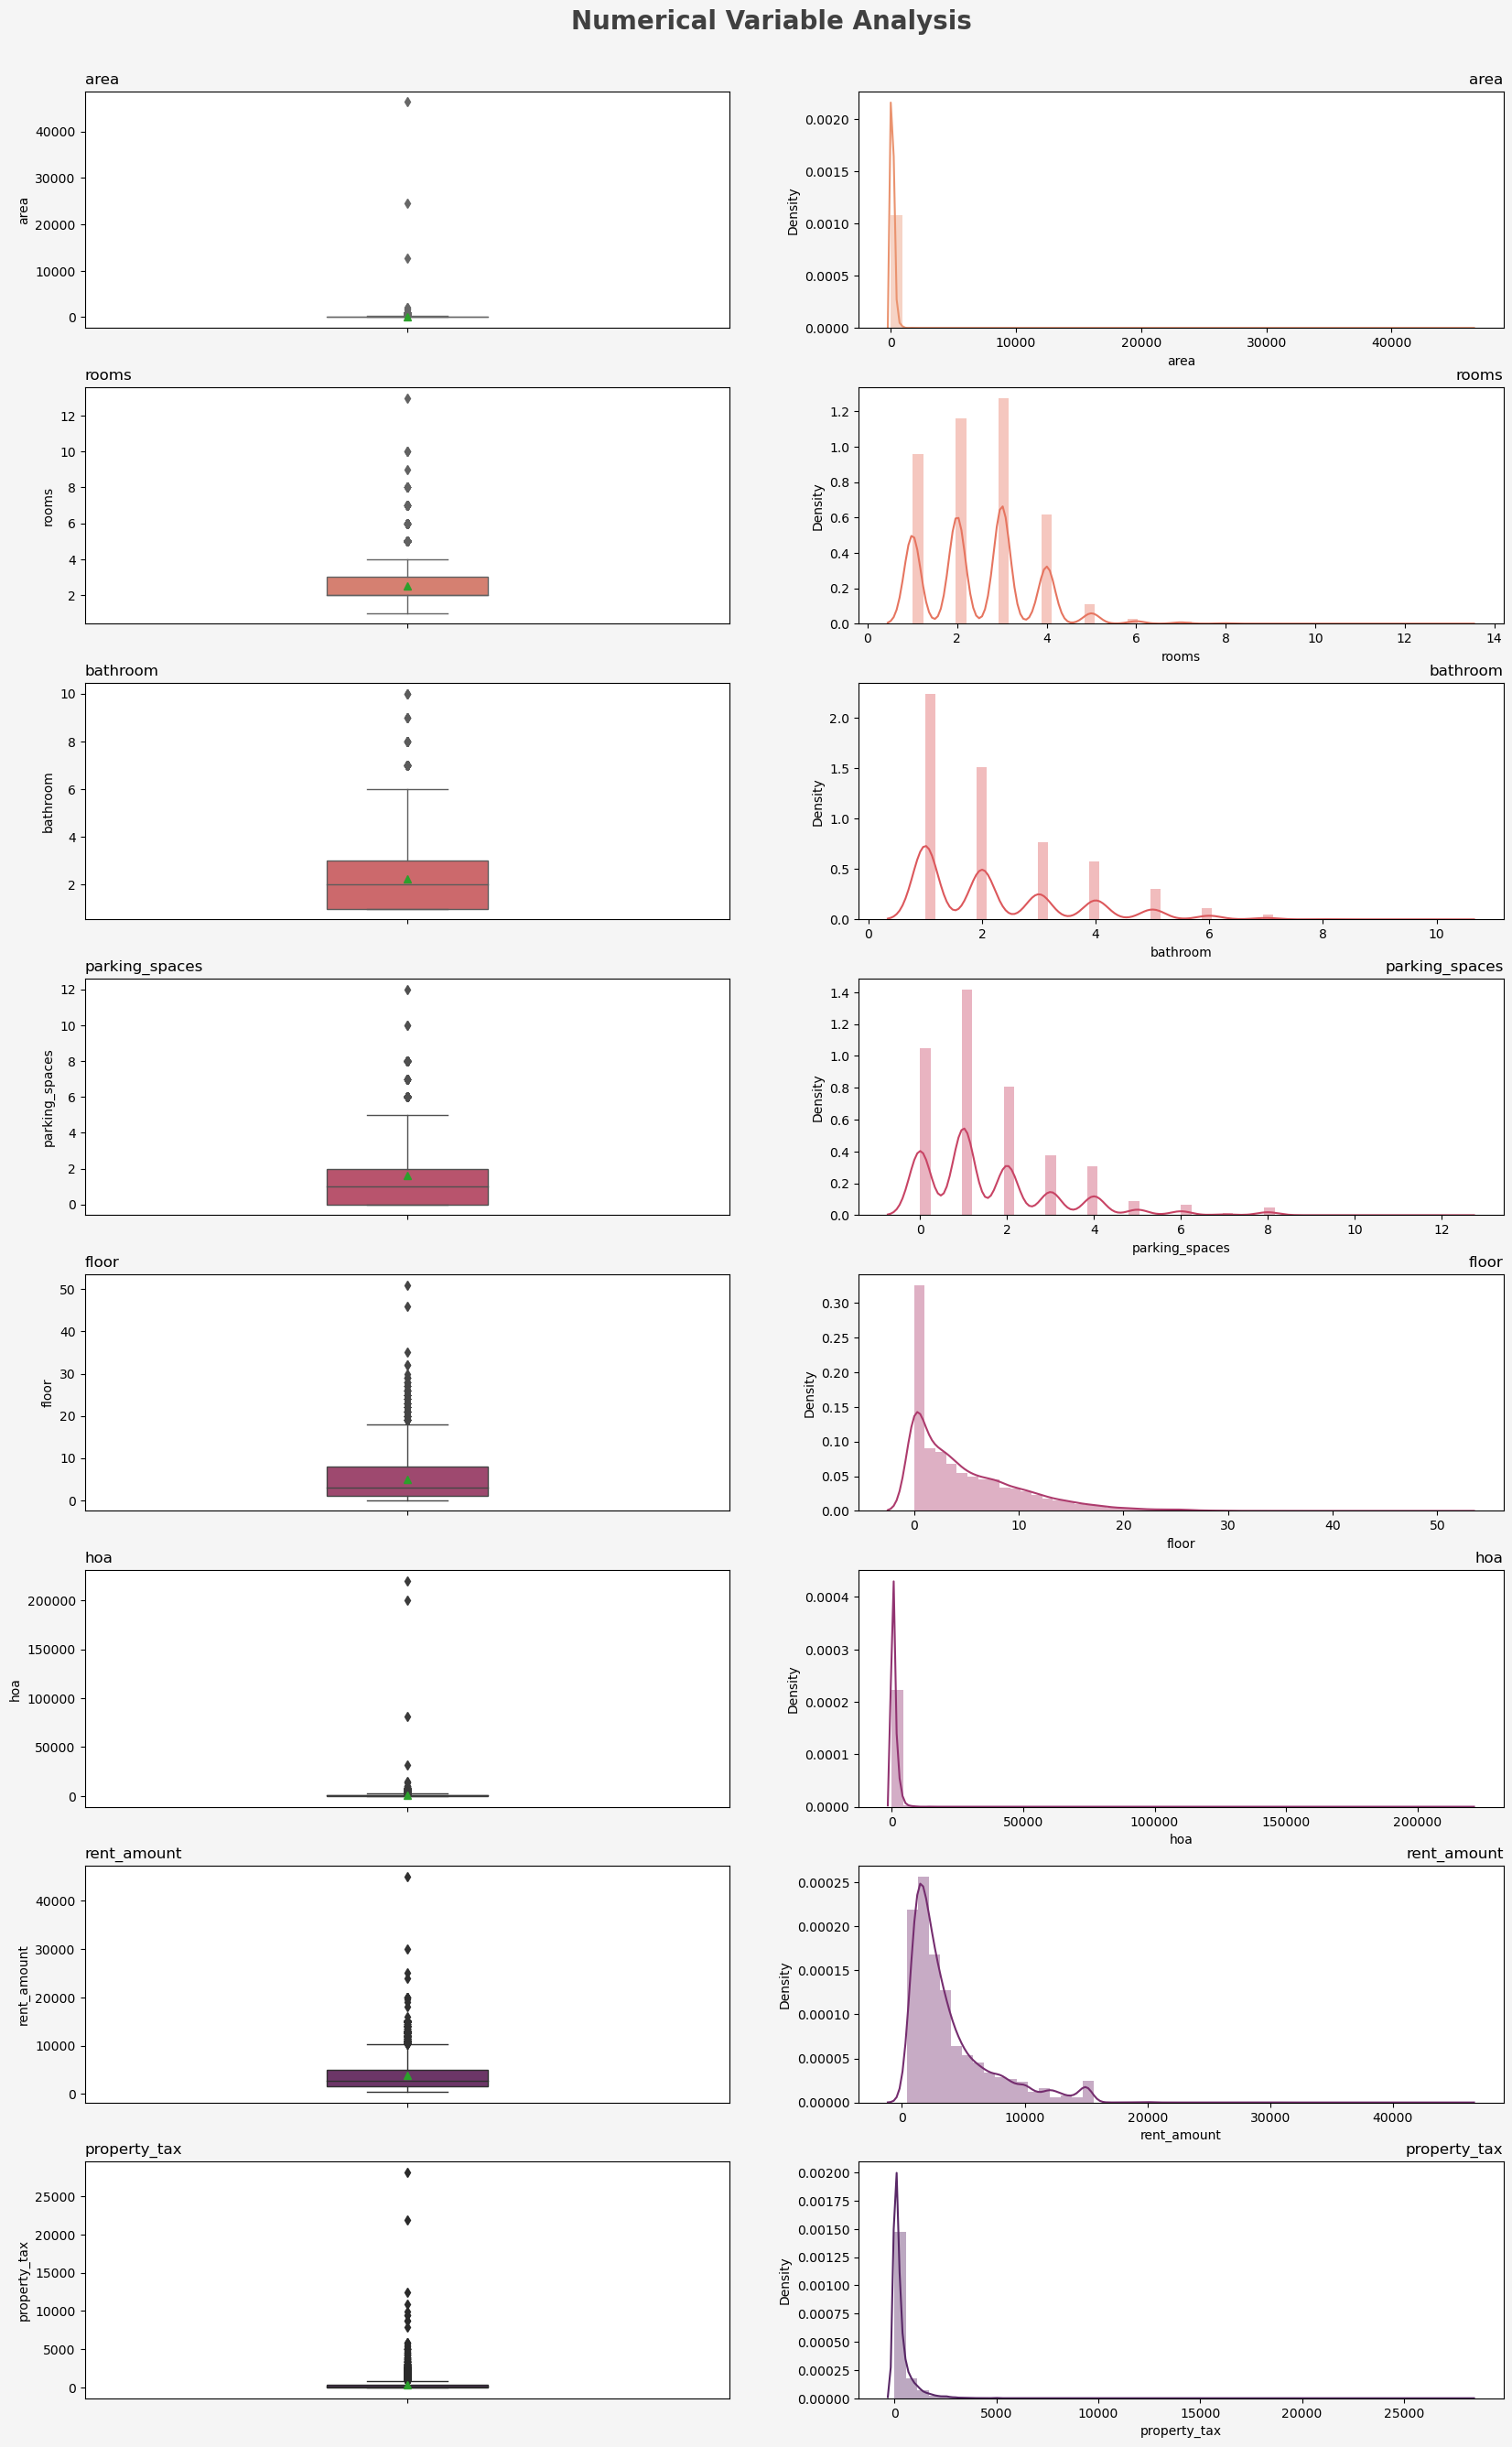

In [340]:
# size
figure, axis = plt.subplots(figsize = (20,30))

#Background
background = "#f5f5f5"
figure.set_facecolor(background)

#Color pallete
color_palette = sns.color_palette('flare', len(num_cols) * 2)

#Title
plt.suptitle("Numerical Variable Analysis", fontsize = 20, color = "#404040", fontweight = 600)

#Structure plot
lines = len(num_cols)
columns = 2
position = 1

for column in num_cols:

    #Boxplot
    plt.subplot(lines, columns, position)

    #Title
    plt.title(f'{column}', loc = 'left', fontsize = 12, fontweight = 200)

    #plot
    sns.boxplot(data = df2, y = column, showmeans = True, saturation = 0.75,
                linewidth=1, color = color_palette[position], width = 0.25)

    #change position
    position += 1

    #Distplot
    plt.subplot(lines, columns, position)

    #Title
    plt.title(f'{column}', loc = 'right', fontsize = 12, fontweight = 200)

    sns.distplot(df2[column], color = color_palette[position-1])

    #change position
    position += 1

#Adjust Grid
plt.subplots_adjust(top = .95, hspace = 0.25)

<AxesSubplot:>

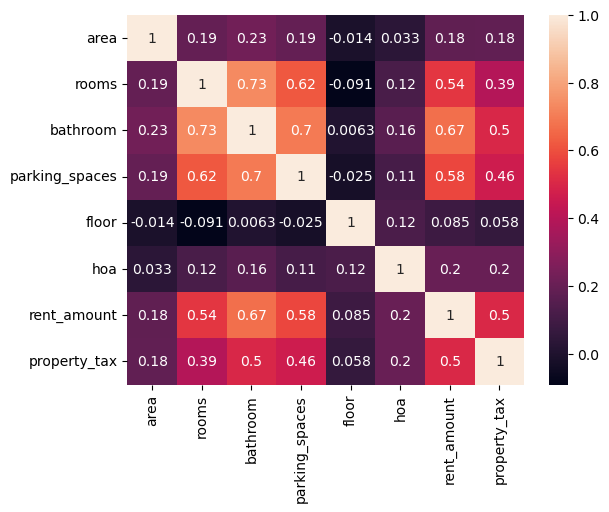

In [364]:
numerical_cols = df2.select_dtypes(exclude=['object'])
correlation = numerical_cols.corr(method = 'pearson')
sns.heatmap(correlation, annot = True)

## 2.2. Categorical Variables


In [365]:
a = df2.select_dtypes(include = ['object'])
a.head()

,city,animal,furniture
0,São Paulo,acept,furnished
1,São Paulo,acept,not furnished
2,Porto Alegre,acept,not furnished
3,Porto Alegre,acept,not furnished
4,São Paulo,not acept,not furnished


In [ ]:
# Calculate Cramer V
a1 = cramer_v(a['city'], a['animal'])
a2 = cramer_v(a['city'], a['city'])
a3 = cramer_v(a['city'], a['forniture'])


# 3.0 Data Preparation

In [341]:
df3 = df2.copy()

## 3.1. Split dataframe in train and test

In [352]:
X = df3.drop(columns = 'rent_amount', axis = 1)
y = df3['rent_amount'].copy()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 21)

## 3.1. Normalization

Não haverá normalização dos dados pois não há nenhuma variável com distribuição normal

# 6.0 Feature Selection

# 7.0 Machine Learning Modelling

# 8.0 Hyperparameter Fine Tuning

# 9.0 Translation and Interpretration Error